# Electricity Consumption Forecasting

In [1]:
# Install Packages and laod libraries

# SUPPRESS PACKAGE WARNINGS
quietly <- suppressPackageStartupMessages

# DISABLE SCIENTIFIC NOTATION
options(scipen = 9999)

# LOAD PACKAGES SUPRESS WARNINGS
quietly(library(xlsx))
quietly(library(forecast))
quietly(library(xts))
quietly(library(ggplot2))

In [2]:
# Load the data and Analyse it

data <- read.xlsx(file = 'Elec-train.xlsx', sheetName = 'Feuil1')
head(data)

Timestamp,Power..kW.,Temp..C..
1/1/2010 1:15,165.1,10.55556
1/1/2010 1:30,151.6,10.55556
1/1/2010 1:45,146.9,10.55556
1/1/2010 2:00,153.7,10.55556
1/1/2010 2:15,153.8,10.55556
1/1/2010 2:30,159.0,10.55556


In [3]:
#data Formatting
class(data)

[1] "data.frame"

In [4]:
dim(data)

[1] 4603    3

In [5]:
# RENAME THE COLUMNS
names(data)[2]<-"Power"
names(data)[3]<-"Temperature"

In [6]:
#COLUMN FORMATTING - ORIGINAL DATASET
class(data$Timestamp)
data$Timestamp <- as.POSIXct(data$Timestamp, format ="%m/%d/%Y %H:%M", tz = "GMT")
data$Date <- as.Date(data$Timestamp)
data$Time <- format(data$Timestamp,"%H:%M")

myts_power <- ts(data$Power, frequency = 96)
myts_temperature <- ts(data$Temperature, frequency = 96)
myts_time<- as.numeric(time(myts_power))

[1] "factor"

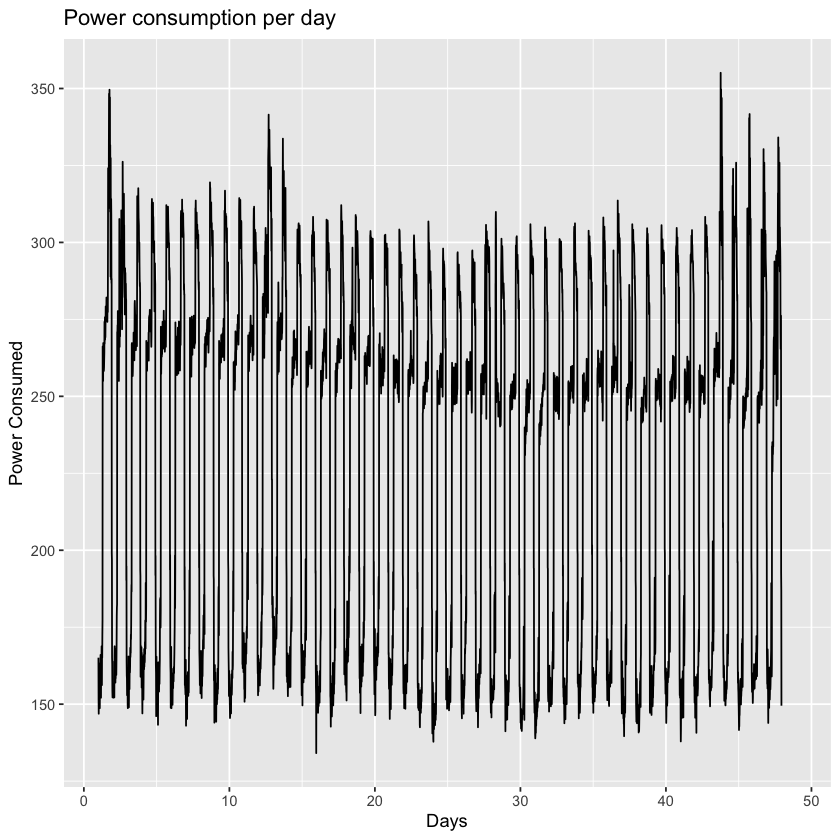

In [7]:
#Power Consumption per day
par(mfrow=c(2,1))
autoplot(myts_power) +
  ggtitle('Power consumption per day') +
  xlab('Days') +
  ylab('Power Consumed')

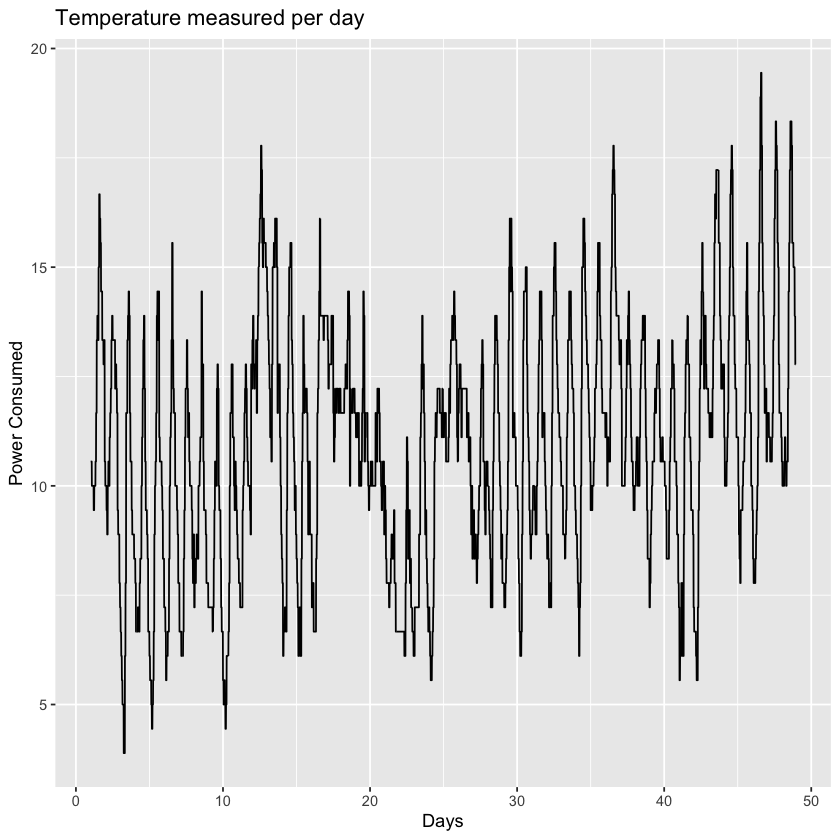

In [8]:
#Temperature measured per day
autoplot(myts_temperature) +
  ggtitle('Temperature measured per day') +
  xlab('Days') +
  ylab('Power Consumed')

## Data Preprocessing

In [9]:
#Split data into Test, Train and Validation sets
nValidationDays <- 2
test_power <- tail(myts_power, 96)
data_minus_test_set <- head(myts_power, -96)
train_power <- head(data_minus_test_set, -nValidationDays*96)
validation_power <- tail(data_minus_test_set, nValidationDays*96)

nrow(data) #total entires in rows in original dataset = 4603
length(data_minus_test_set) #total Rows in dataset - Test Set = 4603 - 96 = 4507
length(train_power) #total training set size = 4507 - 2*96 = 4315
length(validation_power) # validation set size = 2*96 = 192
length(test_power) #total test set entries to be predicted= 96

[1] 4603

[1] 4507

[1] 4315

[1] 192

[1] 96

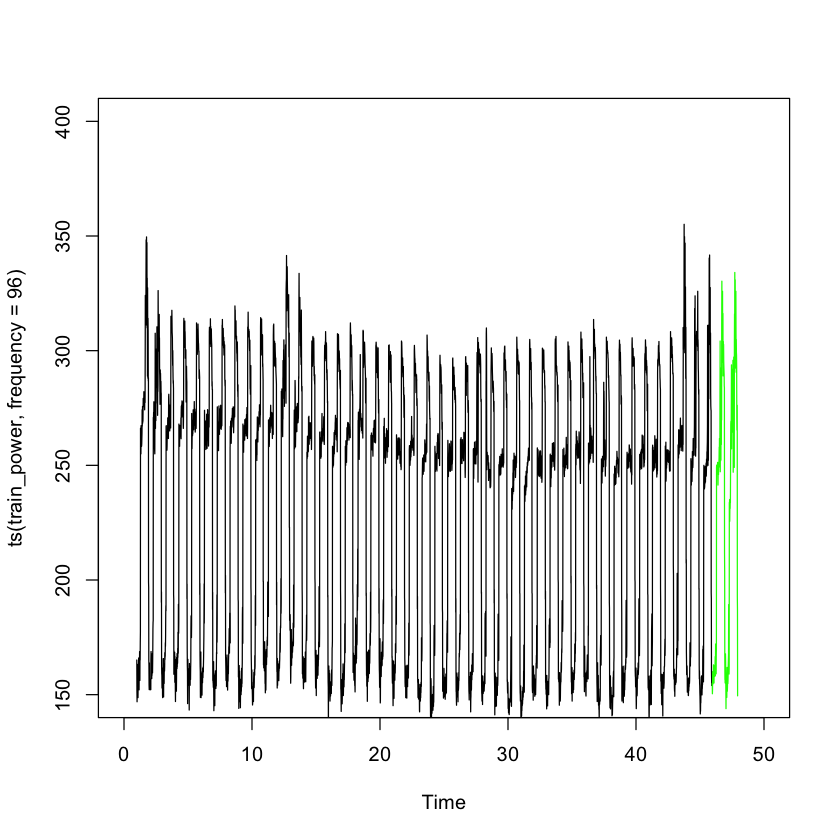

In [10]:
test_time <- tail(myts_time, 96)
data_minus_test_set_time <- head(myts_time, -96)
train_time <- head(as.numeric(time(data_minus_test_set_time)), -nValidationDays*96)
validation_time <- tail(as.numeric(time(data_minus_test_set)), nValidationDays*96)
plot(ts(train_power, frequency = 96),xlim=c(0,50),ylim=c(150,400))
par(new=TRUE)
lines(validation_time, validation_power, col="green", xlim=c(0,50))

## Forecasting without covariates

### Simple Exponential Smoothing Models

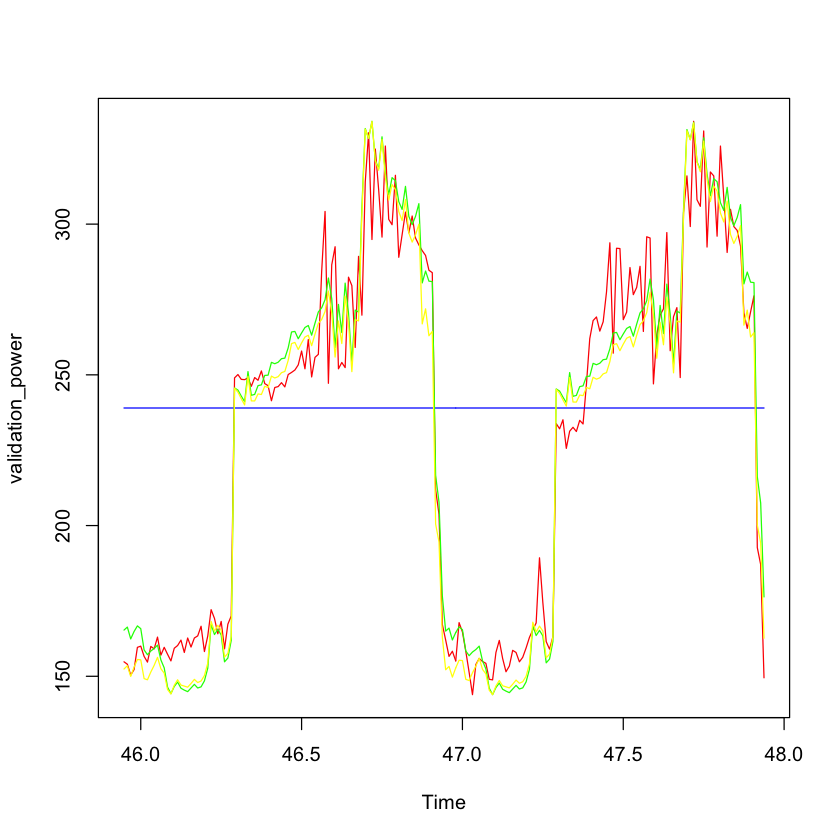

In [11]:
plot(validation_power,col="red") #original validation data series
fit1_SES=HoltWinters(train_power,alpha=NULL,beta=FALSE,gamma=FALSE) #auto alpha selection
p1_SES<-predict(fit1_SES,n.ahead=length(validation_power))
par(new=TRUE)
plot(p1_SES,col="blue",ann=FALSE, axes=FALSE) #predicted values only alpha - Linear Simple Exponential Smoothing

fit2_SES=HoltWinters(train_power,alpha=NULL,beta=NULL,gamma=NULL) #Additive seasonal Holt-Winters
p2_SES<-predict(fit2_SES,n.ahead=length(validation_power))
par(new=TRUE)
plot(p2_SES,col="green",ann=FALSE, axes=FALSE) #predicted values

fit3_SES=HoltWinters(train_power,alpha=NULL,beta=NULL,gamma=NULL,seasonal = "multi") #Multiplicative seasonal Holt-Winters
p3_SES<-predict(fit3_SES,n.ahead=length(validation_power))
par(new=TRUE)
plot(p3_SES,col="yellow",ann=FALSE, axes=FALSE) #predicted values

In [12]:
#Error Calculations for SES Models and comparing them
y=as.numeric(validation_power)
yhat1=as.numeric(p1_SES)
yhat2=as.numeric(p2_SES)
yhat3=as.numeric(p3_SES)

err1_SES=sqrt(mean((y-yhat1)^2))
err2_SES=sqrt(mean((y-yhat2)^2)) 
err3_SES=sqrt(mean((y-yhat3)^2)) 

err1_SES #ERROR - Linear Simple Exponential Smoothing
err2_SES #ERROR - Additive seasonal Holt-Winters
err3_SES #ERROR - Multiplicative seasonal Holt-Winters

[1] 95.29608

[1] 27.1134

[1] 23.57969

Warning message:
“Removed 192 row(s) containing missing values (geom_path).”Warning message:
“Removed 768 row(s) containing missing values (geom_path).”

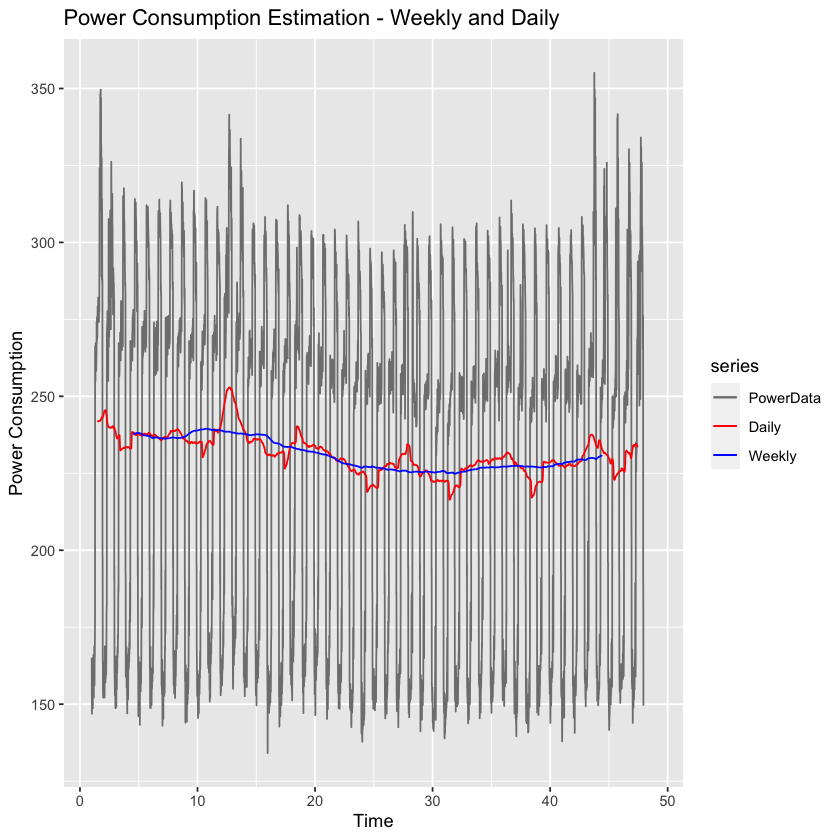

In [13]:
#Power consumption estimation by moving average
PowerData = myts_power #We consider whole data for this visualization - to get the entire picture
autoplot(PowerData, series="PowerData") + 
  autolayer(ma(PowerData,96), series="Daily") + 
  autolayer(ma(PowerData,96*7), series="Weekly") + 
  xlab("Time") + ylab("Power Consumption") + 
  ggtitle("Power Consumption Estimation - Weekly and Daily") + 
  scale_colour_manual(values=c("PowerData"="grey50","Daily"="red","Weekly"="blue"),
                      breaks=c("PowerData","Daily","Weekly"))

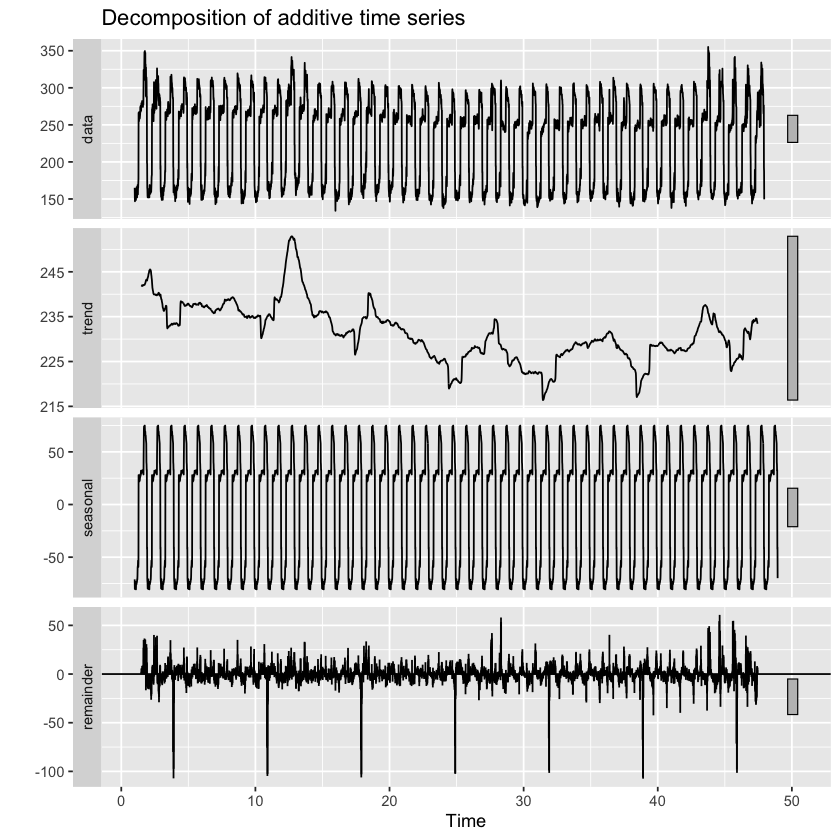

In [14]:
#Decomposition of additive time series - decompose function
autoplot(decompose(PowerData,type="additive"))+ xlab('Time')

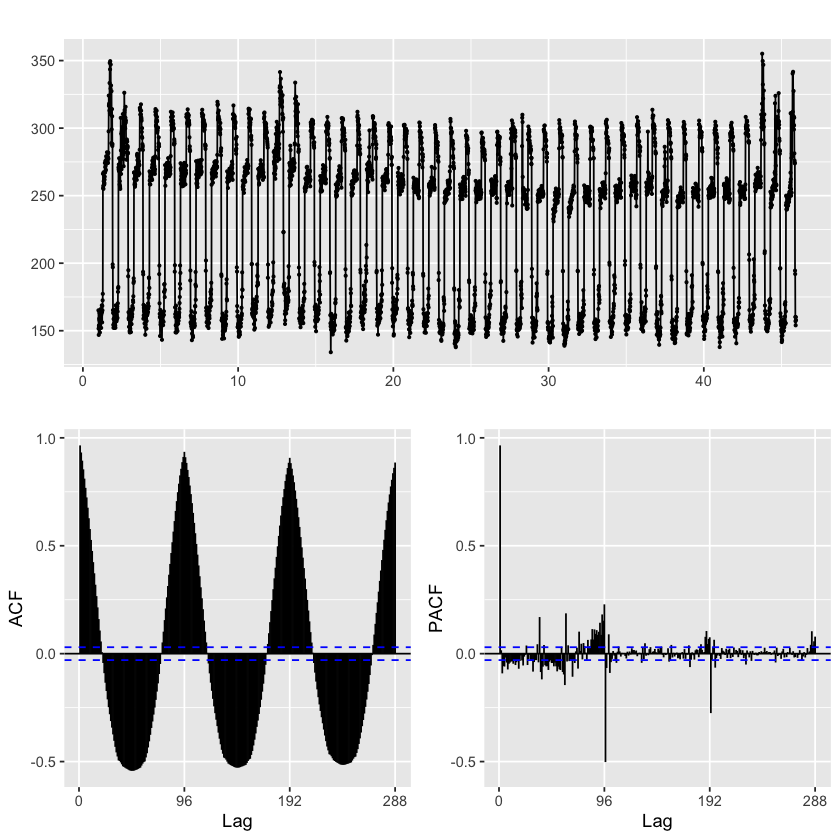

In [15]:
ggtsdisplay(train_power) # To get ACF and PACF for training data

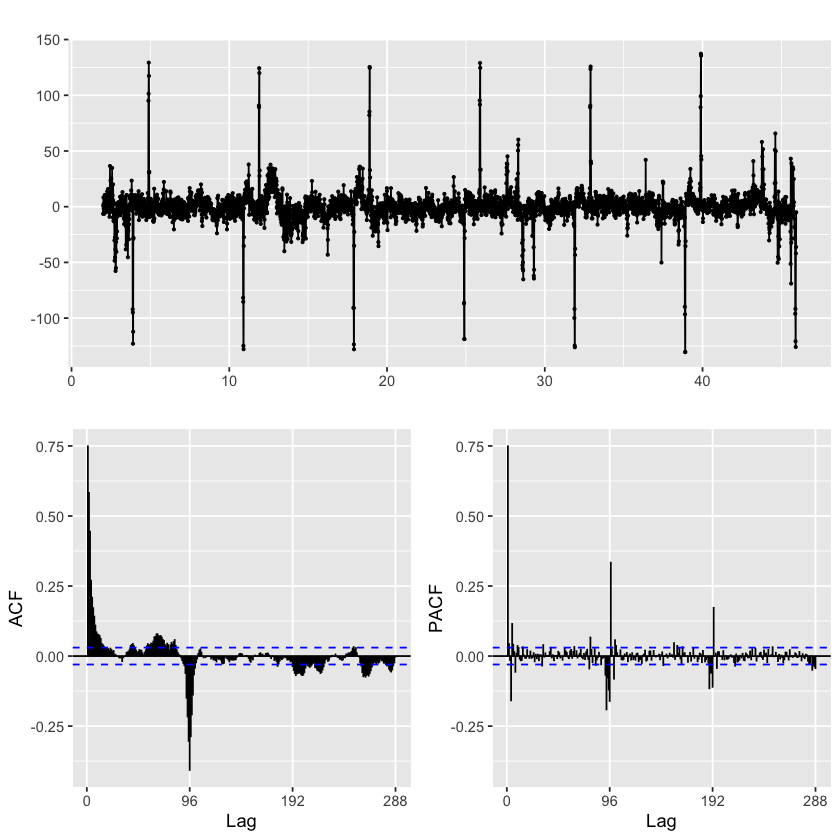

In [16]:
ggtsdisplay(diff(train_power,lag=96,differences=1)) #no more seasonality??

In [17]:
#Test for white Noise - Ljung-Box Test
Box.test(diff(train_power,lag=96,differences=1),lag=10,type="Ljung-Box")


	Box-Ljung test

data:  diff(train_power, lag = 96, differences = 1)
X-squared = 5512.6, df = 10, p-value < 0.00000000000000022


Since p-value is quite low, we reject H0. i.e. its NOT all white noise. There is some auto correlation to be modelized.

### Auto Arima Model

In [18]:
#Automatic Method
fit4_AutoArima = auto.arima(train_power)
fit4_AutoArima

Series: train_power 
ARIMA(4,0,4)(0,1,0)[96] 

Coefficients:
         ar1      ar2      ar3     ar4     ma1     ma2     ma3      ma4
      0.6735  -0.1638  -0.0470  0.1712  0.0554  0.2753  0.3476  -0.1623
s.e.  0.1644   0.0846   0.0718  0.0600  0.1645  0.0849  0.0947   0.0497

sigma^2 estimated as 104.7:  log likelihood=-15794.99
AIC=31607.97   AICc=31608.02   BIC=31665.1

[1] 27.71782

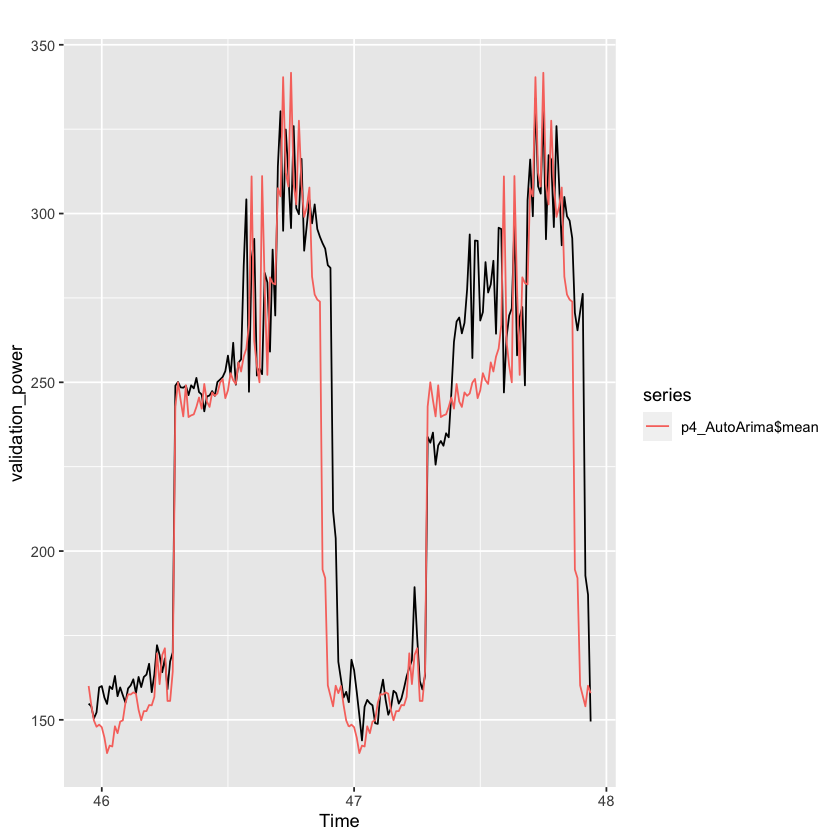

In [19]:
#Prediction and error computation with Auto Arima method
p4_AutoArima=forecast(fit4_AutoArima,h=length(validation_power))
autoplot(validation_power)+autolayer(p4_AutoArima$mean)
y=as.numeric(validation_power)
yhat4=(p4_AutoArima$mean)
err4_AutoArima=sqrt(mean((y-yhat4)^2))
err4_AutoArima

### Manual Arima Model

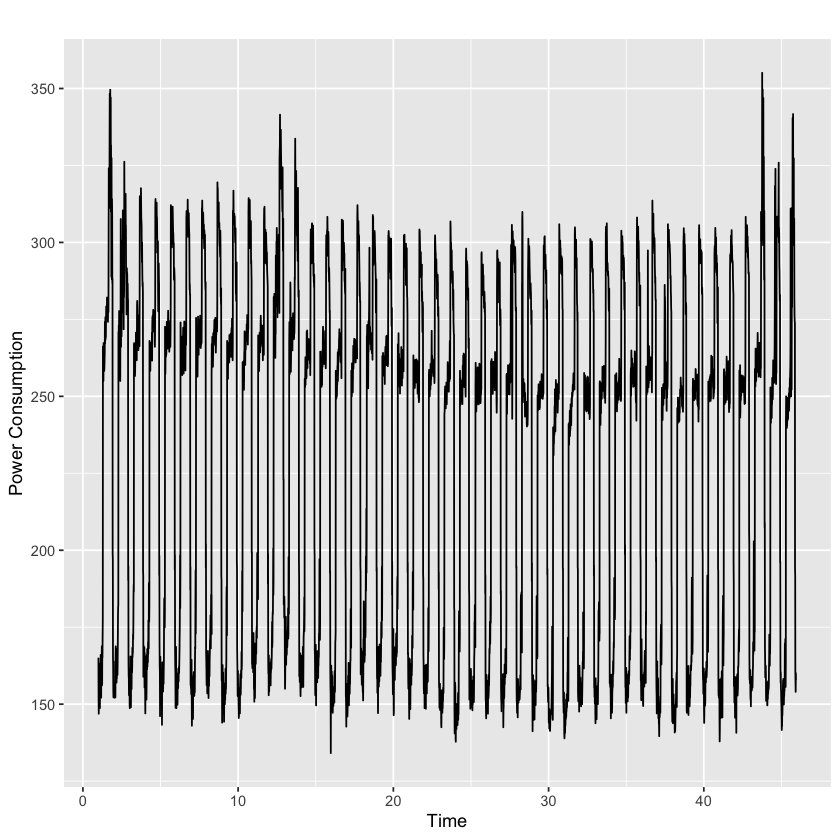

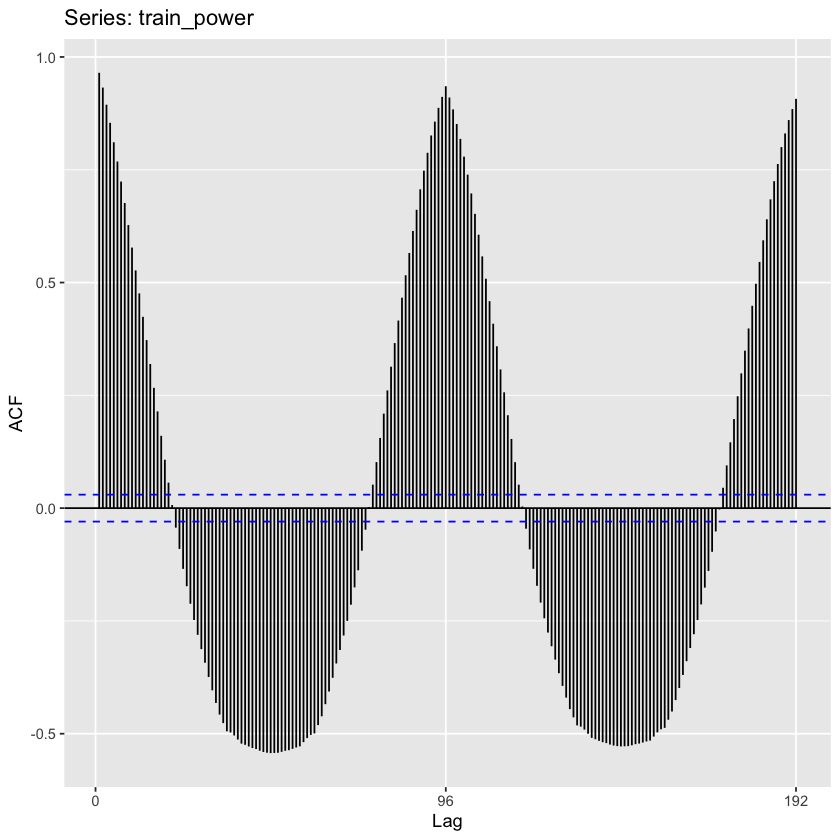

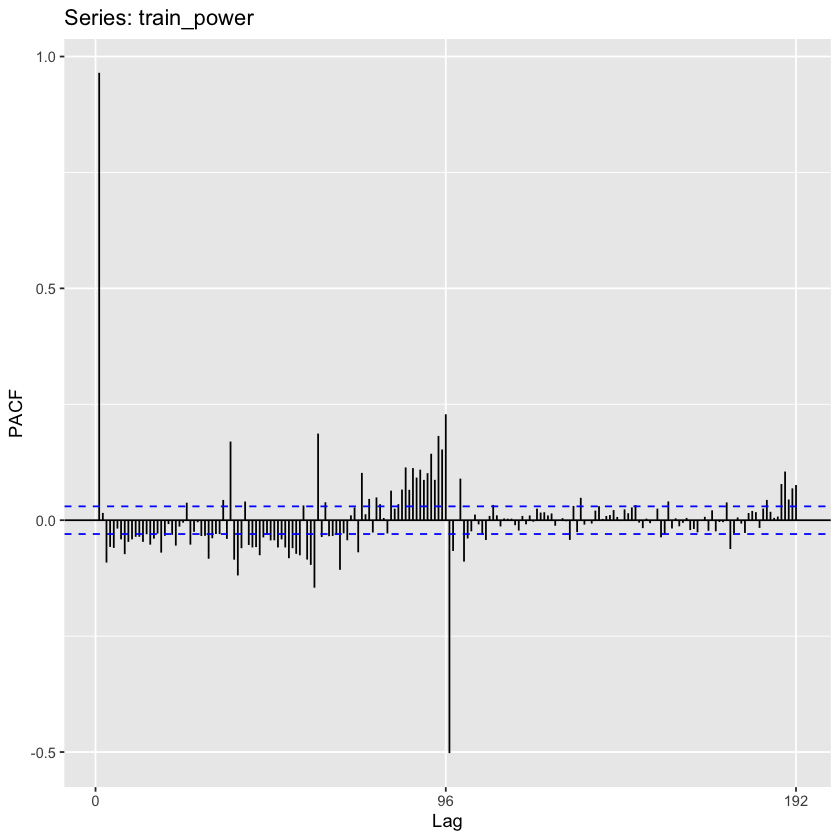

In [20]:
autoplot(train_power) + xlab("Time") + ylab("Power Consumption")
par(mfrow=c(2,1))
ggAcf(train_power)
ggPacf(train_power)

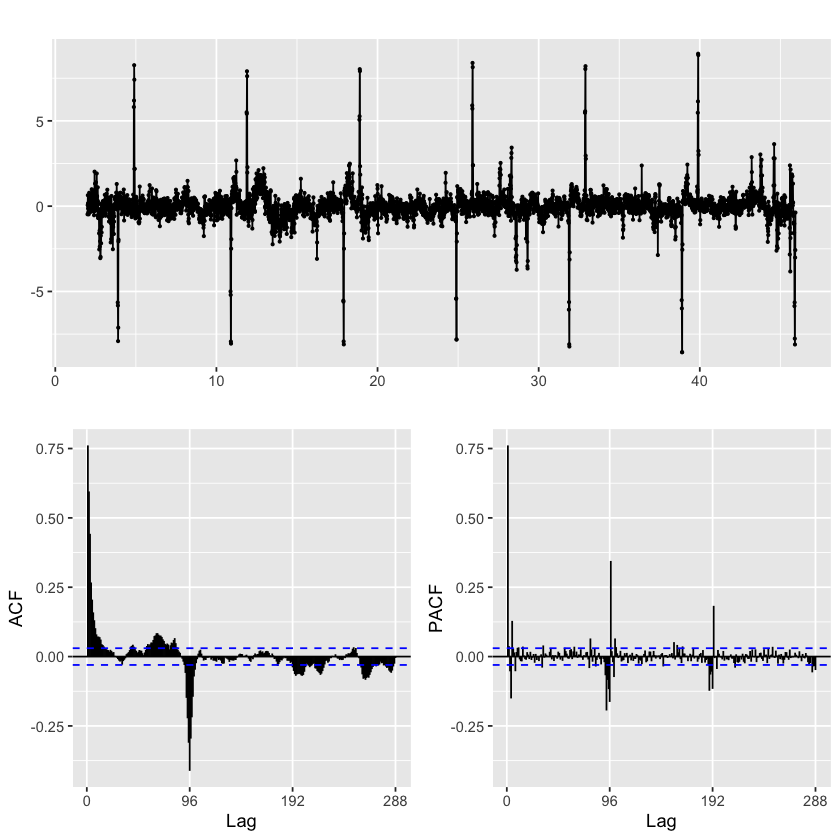

In [21]:
#remove seasonality with lag 96
lambda=BoxCox.lambda(train_power) 
Elec_train_BC=BoxCox(train_power,lambda)
tmp=diff(Elec_train_BC,lag=96, differences = 1) 
ggtsdisplay(tmp)

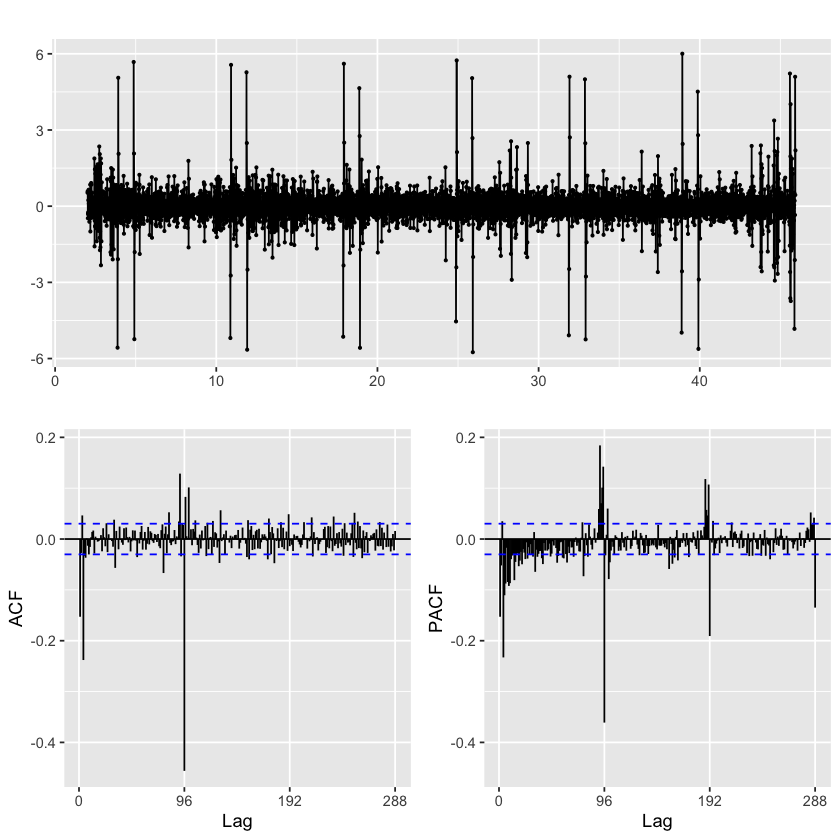

In [22]:
#to get rid of any trend
tmp2 = diff(tmp)
ggtsdisplay(tmp2)

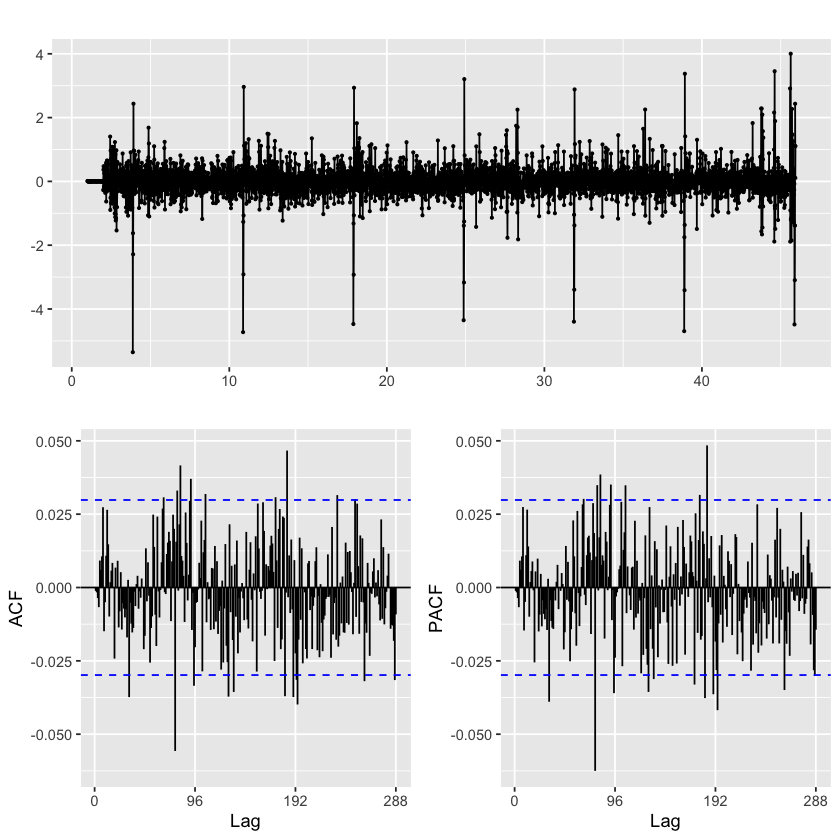

In [23]:
#first manual model we can try
fit5_ManualSarima1=Arima(train_power, order=c(4,1,4), seasonal=c(0,1,1),lambda = "auto")
fit5_ManualSarima1 %>% residuals() %>% ggtsdisplay()


	Box-Ljung test

data:  fit5_ManualSarima1$residuals
X-squared = 5.5899, df = 2, p-value = 0.06112


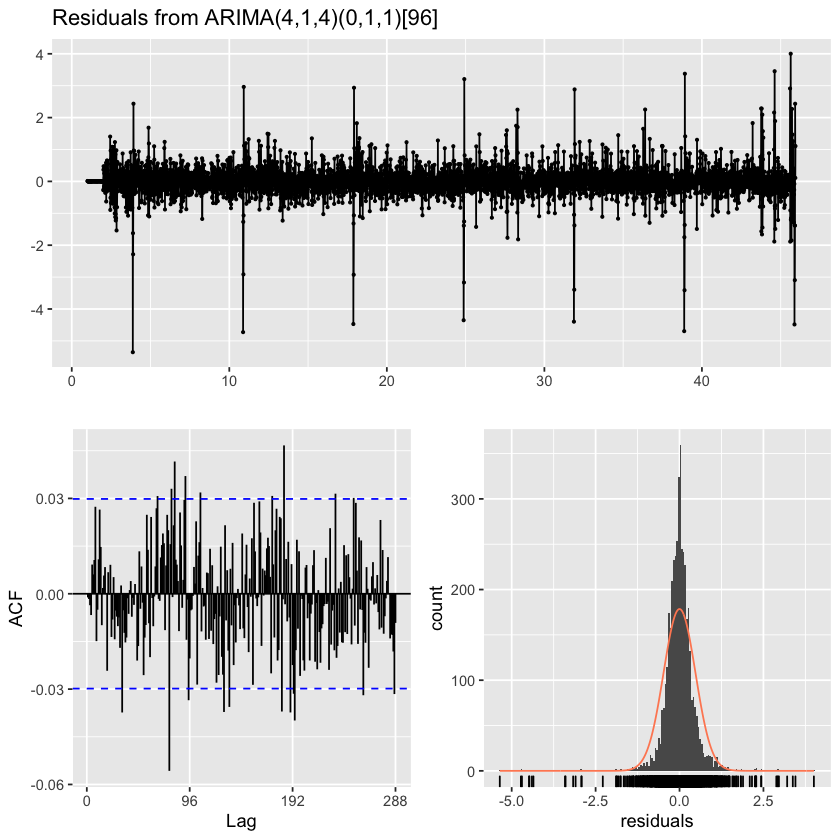

In [24]:
#Checking residuals for fit5_ManualSarima1
checkresiduals(fit5_ManualSarima1, test=FALSE, plot=TRUE)
Box.test(fit5_ManualSarima1$residuals, lag=10, type="Ljung-Box", fitdf=8)

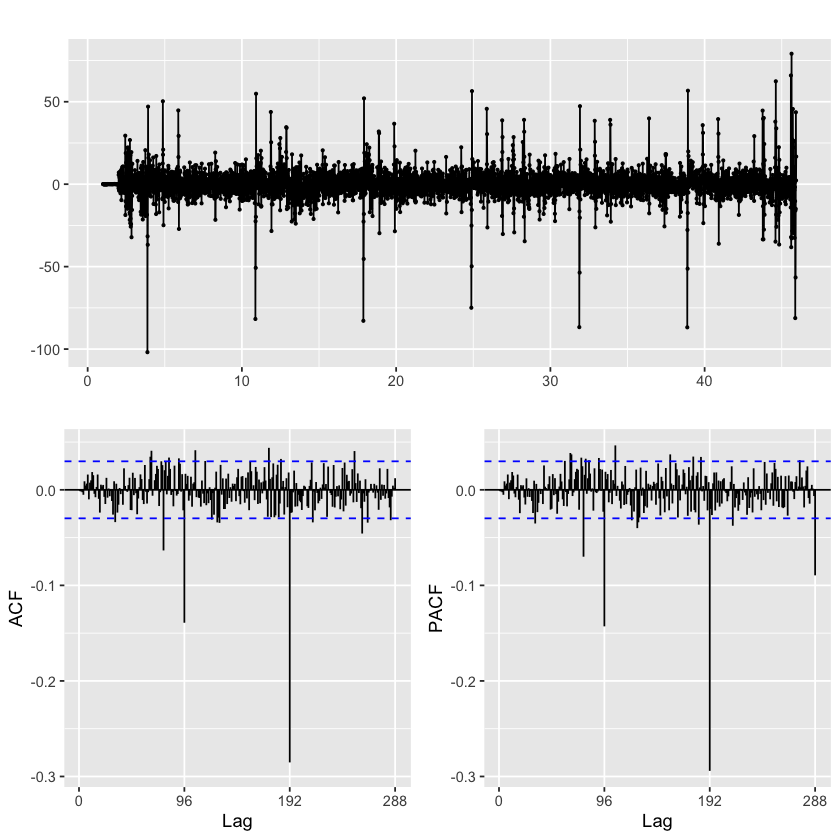

In [25]:
#seconf manual model we can try
fit6_ManualSarima2=Arima(train_power, order=c(4,1,4), seasonal=c(1,1,0)) 
fit6_ManualSarima2 %>% residuals() %>% ggtsdisplay()


	Box-Ljung test

data:  fit6_ManualSarima2$residuals
X-squared = 2.5581, df = 2, p-value = 0.2783


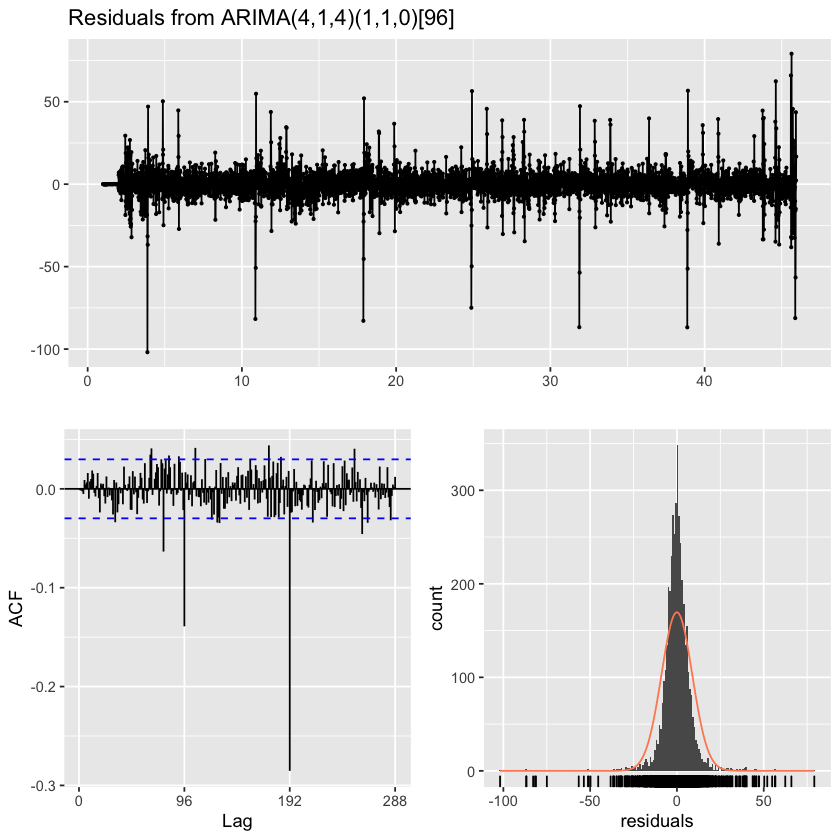

In [26]:
##Checking residuals for fit6_ManualSarima2
checkresiduals(fit6_ManualSarima2, test=FALSE, plot=TRUE)
Box.test(fit6_ManualSarima2$residuals, lag=10, type="Ljung-Box", fitdf=8)

[1] 16.40183

[1] 27.89901

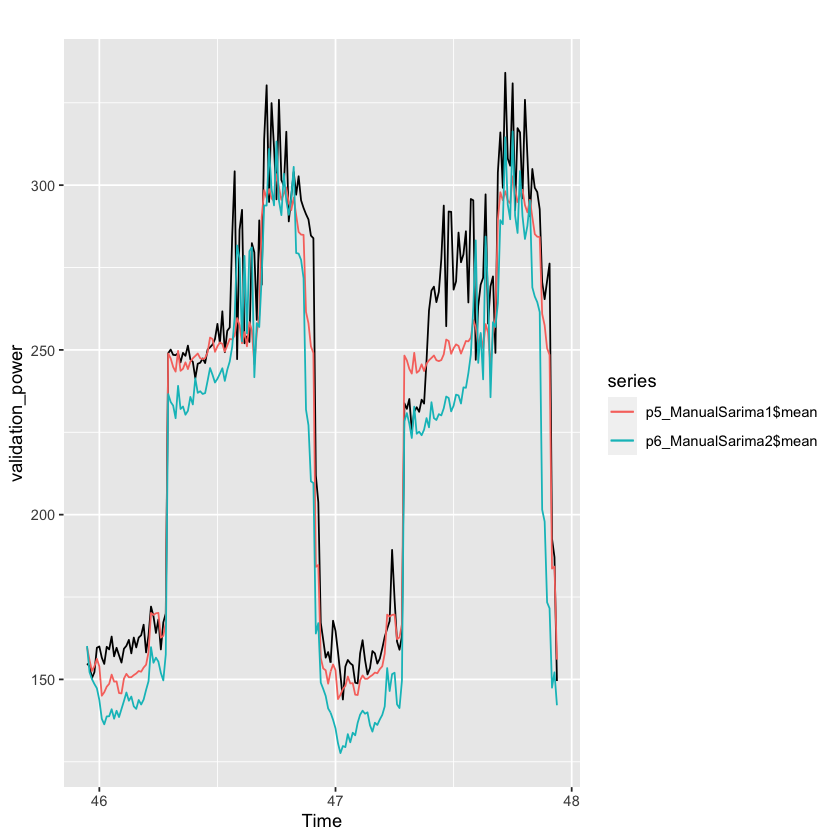

In [27]:
#Model's Prediction, Plot and Error Calculation
p5_ManualSarima1=forecast(fit5_ManualSarima1,h=length(validation_power))
p6_ManualSarima2=forecast(fit6_ManualSarima2,h=length(validation_power))
autoplot(validation_power)+autolayer(p5_ManualSarima1$mean)+autolayer(p6_ManualSarima2$mean)
y=as.numeric(validation_power)
yhat5=(p5_ManualSarima1$mean)
yhat6=(p6_ManualSarima2$mean)
err5_AutoArima=sqrt(mean((y-yhat5)^2))
err6_AutoArima=sqrt(mean((y-yhat6)^2))
err5_AutoArima
err6_AutoArima

we select manual model SARIMA(4,1,4)(0,1,1)[96]. 

### Neural Network Model

In [28]:
fit8_nn=nnetar(train_power)
print(fit8_nn)

Series: train_power 
Model:  NNAR(11,1,6)[96] 
Call:   nnetar(y = train_power)

Average of 20 networks, each of which is
a 12-6-1 network with 85 weights
options were - linear output units 

sigma^2 estimated as 76.32


In [29]:
#Plot and calculate the error. 
p8_nn=forecast(fit8_nn,h=length(validation_power))
yhat8=(p8_nn$mean)
err8_nn=sqrt(mean((y-yhat8)^2))
err8_nn

[1] 22.49537

### Compare nn model with our best SES and SARIMA models on Validation set!

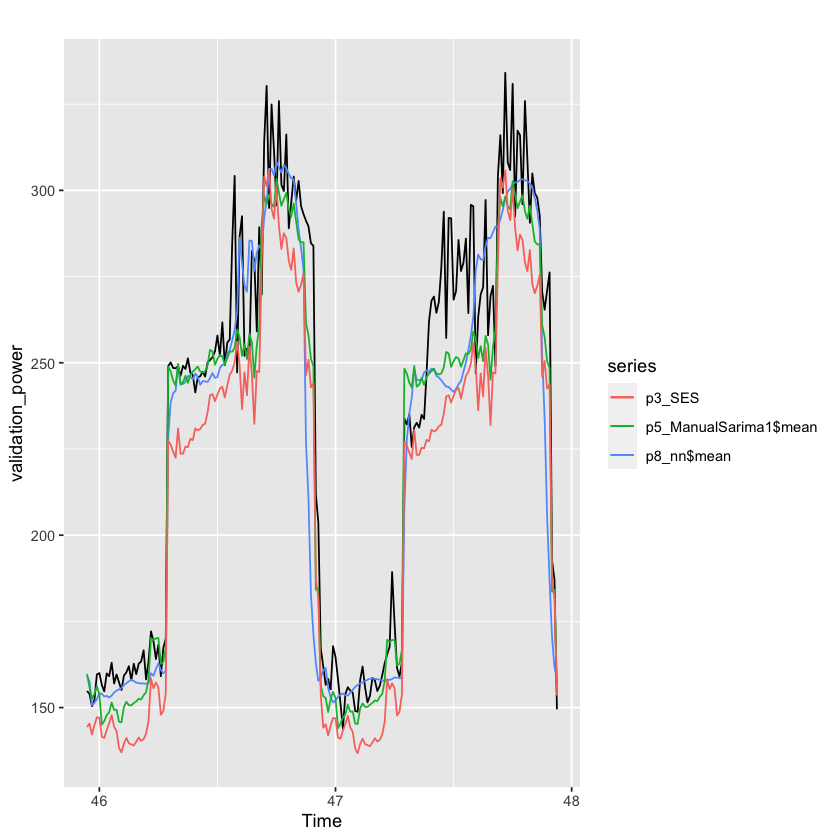

In [30]:
autoplot(validation_power)+autolayer(p8_nn$mean)+autolayer(p5_ManualSarima1$mean)+autolayer(p3_SES)

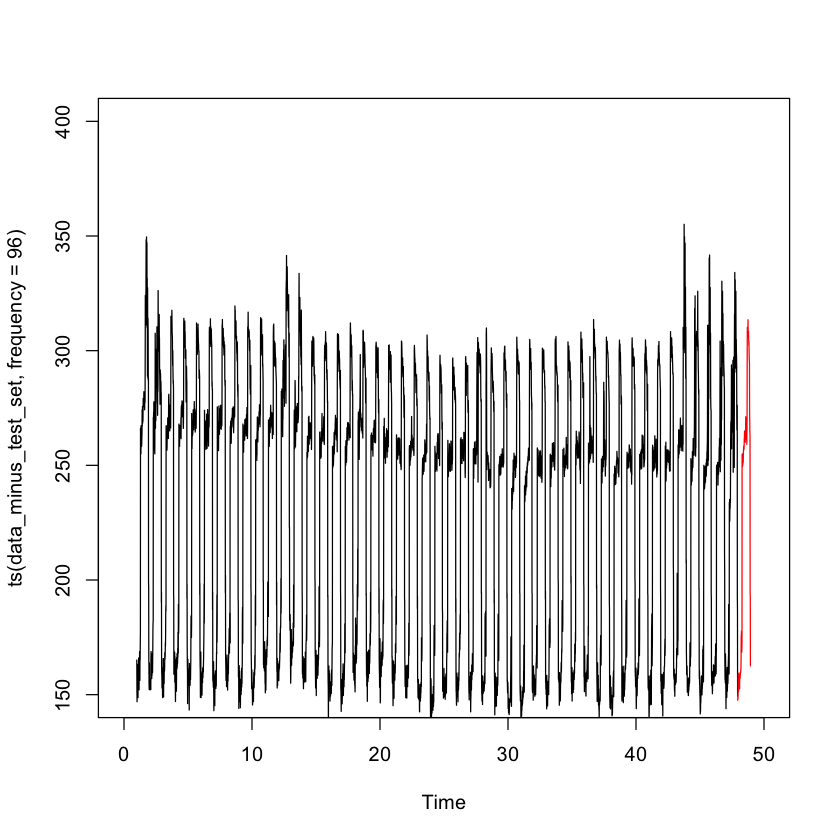

In [11]:
#Forecast TEST set with our best model
final_fit=Arima(data_minus_test_set, order=c(4,1,4), seasonal=c(0,1,1),lambda = "auto")
pred_bestfit_testdata=forecast(final_fit,h=length(test_power))
test_power = pred_bestfit_testdata$mean
plot(ts(data_minus_test_set, frequency = 96),xlim=c(0,50),ylim=c(150,400))
par(new=TRUE)
lines(test_time, test_power, col="red", xlim=c(0,50))